# Benchmarks

This notebook will calculate benchmarks/baselines used in the thesis.

The following benchmarks are implemented in this notebook:

1. Simple heuristics
    - Predict the previous value
    - Predict the mean of the training data
    - Predict the moving average of the sequence
2. Linear regression
    - Linear regression using least squares minimisation
    - Ridge regression
    - LASSO
    - Elastic Nets (ElNet)
3. Simpler Machine Learning
    - Random Forest (RF)
    - Gradient Boosting Machines (GBM)

In [1]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

from functions import MAE, RMSE, split_dataset

# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

## Loading the data

In [188]:
pd.read_csv(ROOT_PATH+"data/metadata/headers.csv", sep=";", header=None)[0].values

array(['VAL_23-FT-92537-01:X.Value', 'VAL_23-TT-92539:X.Value',
       'VAL_23-PT-92539:X.Value', 'VAL_23-FT-92512:X.Value',
       'VAL_23-FT-92521:X.Value', 'VAL_23-KA-9101-M01-62B:X.Value',
       'VAL_23-KA-9101_APE:VALUE', 'VAL_23-KA-9101_APH:VALUE',
       'VAL_23-KA-9101_APR:VALUE', 'VAL_23-KA-9101_ASP:VALUE',
       'VAL_23-KA-9101_EPE:VALUE', 'VAL_23-KA-9101_EPH:VALUE',
       'VAL_23-KA-9101_EPR:VALUE', 'VAL_23-KA-9101_ESP:VALUE',
       'VAL_23-KA-9101_PHD:VALUE', 'VAL_23-KA-9101_PRD:VALUE',
       'VAL_23-KA-9101_SPD:VALUE', 'VAL_23-LIC-92521:Z.X.Value',
       'VAL_23-LIC-92521:Z.Y.Value', 'VAL_23-LT-92523:Z.X1.Value',
       'VAL_23-LT-92523:Z.X2.Value', 'VAL_23-PDT-92502:X.Value',
       'VAL_23-PDT-92522:X.Value', 'VAL_23-PDT-92530:X.Value',
       'VAL_23-PDT-92534:X.Value', 'VAL_23-PT-92504:X.Value',
       'VAL_23-PT-92512:X.Value', 'VAL_23-PT-92521:X.Value',
       'VAL_23-PT-92523:X.Value', 'VAL_23-PT-92532:X.Value',
       'VAL_23-PT-92535:X.Value', 'VAL_23-TIC-92

In [189]:
def read_files(path, method):
    if method=="scaled":
        train = np.load("{0}data_scaled_train.npy".format(path))
        valid = np.load("{0}data_scaled_valid.npy".format(path))
        test = np.load("{0}data_scaled_test.npy".format(path))
    else:
        train = np.load("{0}train_{1}.npy".format(path,method))
        valid = np.load("{0}valid_{1}.npy".format(path,method))
        test = np.load("{0}test_{1}.npy".format(path,method))
        
    return train, valid, test

def read_metadata():
    path = ROOT_PATH + "data/metadata/"
    stats = pd.read_csv(path + "stats.csv", sep=",")
    
    # tags
    headers = pd.read_csv(ROOT_PATH+"data/metadata/headers.csv", sep=";", header=None)[0].values
    target_tags, feature_tags = headers[:3], headers[3:]
    
    # timestamps
    ts = np.load(path + "timestamps/dtimestamps.npy")
    ts_train = np.load(path + "timestamps/ts_train.npy")
    ts_valid = np.load(path + "timestamps/ts_valid.npy")
    ts_test = np.load(path + "timestamps/ts_test.npy")
    
    return headers, target_tags, feature_tags, stats, ts, ts_train, ts_valid, ts_test

In [191]:
scaled_train, scaled_valid, scaled_test = read_files(ROOT_PATH + "data/scaled/", "scaled")
pca_train, pca_valid, pca_test = read_files(ROOT_PATH+"data/feature_selection/pca/", "pca")
bor_train, bor_valid, bor_test = read_files(ROOT_PATH+"data/feature_selection/boruta/", "bor")
headers, target_tags, feature_tags, stats, ts, ts_train, ts_valid, ts_test = read_metadata()

In [195]:
feature_tags

array(['VAL_23-FT-92512:X.Value', 'VAL_23-FT-92521:X.Value',
       'VAL_23-KA-9101-M01-62B:X.Value', 'VAL_23-KA-9101_APE:VALUE',
       'VAL_23-KA-9101_APH:VALUE', 'VAL_23-KA-9101_APR:VALUE',
       'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_EPE:VALUE',
       'VAL_23-KA-9101_EPH:VALUE', 'VAL_23-KA-9101_EPR:VALUE',
       'VAL_23-KA-9101_ESP:VALUE', 'VAL_23-KA-9101_PHD:VALUE',
       'VAL_23-KA-9101_PRD:VALUE', 'VAL_23-KA-9101_SPD:VALUE',
       'VAL_23-LIC-92521:Z.X.Value', 'VAL_23-LIC-92521:Z.Y.Value',
       'VAL_23-LT-92523:Z.X1.Value', 'VAL_23-LT-92523:Z.X2.Value',
       'VAL_23-PDT-92502:X.Value', 'VAL_23-PDT-92522:X.Value',
       'VAL_23-PDT-92530:X.Value', 'VAL_23-PDT-92534:X.Value',
       'VAL_23-PT-92504:X.Value', 'VAL_23-PT-92512:X.Value',
       'VAL_23-PT-92521:X.Value', 'VAL_23-PT-92523:X.Value',
       'VAL_23-PT-92532:X.Value', 'VAL_23-PT-92535:X.Value',
       'VAL_23-TIC-92504:Z.X.Value', 'VAL_23-TT-92502:X.Value',
       'VAL_23-TT-92512:X.Value', 'VAL_23-TT-925

In [140]:
# remove features from the dataset
delete_tags = ["VAL_23-TIC-92504:Z.X.Value", "VAL_23-VA-9110-M01-EL:XS.MeasuredValues.CurrentL2.Value.Value"]
delete_idxs = [np.where(feature_tags == tag)[0][0] for tag in delete_tags]

x_train, y_train = split_dataset(np.delete(scaled_train, delete_idxs, axis=1))
x_valid, y_valid = split_dataset(np.delete(scaled_valid, delete_idxs, axis=1))
x_test, y_test = split_dataset(np.delete(scaled_test, delete_idxs, axis=1))

x_train_delayed = x_train[:-1]
y_train_delayed = y_train[1:]

x_valid_delayed = x_valid[:-1]
y_valid_delayed = y_valid[1:]

x_test_delayed = x_test[:-1]
y_test_delayed = y_test[1:]


print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

# test that the data is lagged correctly
assert len(x_train) == len(x_train_delayed)+1
assert np.all(x_train[-2] == x_train_delayed[-1])
assert len(y_train) == len(y_train_delayed)+1
assert np.all(y_train_delayed[0] == y_train[1])

# test that the features are deleted
assert x_train.shape[-1] == scaled_train.shape[-1]-len(target_tags)-len(delete_tags)

(53211, 39) (53211, 3)
(17737, 39) (17737, 3)


## Global functions for evaluation

In [196]:
def evaluate_error(preds, targets, target_stdevs=stats.loc[:len(target_tags)-1,"Std"].values):
    """
    Will evaluate the MAE of a set of predictions and targets.
    
    :param preds: Matrix of predictions with shape (n_obs, n_target_variables)
    :param targets: Matrix of true targets with shape (n_obs, n_target_variables)
    :param target_stdevs: 1D vector of the standard deviations of the target variables.
    
    :return return_dict: A dictionary with the computed error variables. 
    """
    
    maes = MAE(targets, preds, vector=True)
    maes_unstd = (maes * target_stdevs)
    avg_mae = np.mean(maes)
    avg_mae_unstd = np.mean(maes_unstd)

    err_df = pd.DataFrame(np.column_stack([target_tags, maes, maes_unstd]), 
                          columns=['Tag', 'MAE (Standardized)', 'MAE (Unstandardized)'])
    err_df.loc[len(err_df)] = ["Average", avg_mae, avg_mae_unstd]
    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'err_df': err_df,
        'err_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
        'avg_mae': avg_mae,
        'avg_mae_unstd': avg_mae_unstd
    }
    
    return return_dict

In [197]:
def get_summary(val_dicts, test_dicts, columns, indexes, unstd=False, texpath=None, round_digits=4):
    """
    Method that concatenates validation and test dictionaries (as obtained by evaluate_error()) into a dataframe.
    Is typically used to get a summary of multiple methods and their performance on test and validation data. 
    
    :param val_dicts: Validation dictionaries as obtained by evalueate_error()
    :param test_dicts: Test dictionaries as obtained by evaluate_error()
    :param columns: Vector of column names for the dataframe
    :param indexes: Vector of index names for the dataframe
    :param unstd: Boolean if the MAEs should be unstandardized or not. Default=False. 
    :param texpath: Path to save the obtained latex output. Default=None. 
    :round_digit: The significant digits to round a decimal to, used in format_digit(). Default=4. 
    
    :return: The summary dataframe and the latex string of the dataframe. 
    """
    
    name = 'maes_unstd' if unstd else 'maes'
    val_data = []
    for i, d in enumerate(val_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        val_data.append(tmp)

    test_data = []
    for i, d in enumerate(test_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        test_data.append(tmp)

    val_df = pd.DataFrame(np.vstack(val_data), index = indexes, columns=columns)
    test_df = pd.DataFrame(np.vstack(test_data), index = indexes, columns=columns)
    summary_df = pd.concat([val_df, test_df], axis=1, keys=["Validation", "Test"])
    
    tex = latexify(summary_df)

    if texpath is not None: # save the file
        with open(texpath, 'w+') as f:
            f.write(tex)
    
    return summary_df, tex

# Simple heuristics
---

In [198]:
def evaluate_heuristic(func, y_valid, y_test):
    """
    Evaluates a heuristic by printing results for the validation and testing data.
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :return val_errs, test_errs: The dictionaries obtained by the evaluate_error()-function. 
    """
    
    print("\n       Validation data")
    preds, targets = func(y_valid)
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\n       Testing data")
    preds, targets = func(y_test)
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

In [199]:
def visualise_heuristic(func, y_data=y_valid, n_obs=100, signal=1):
    """
    Visualises the heuristic with a sample plot. 
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :param y_data: The data with the true targets. Default set to y_valid. 
    :param n_obs: The number of observations that will be plotted. Default set to 100. 
    :param signal: The target that will be plotted. Default set to 1, i.e. the temperature. 
    """
    
    preds, targets = func(y_data)
    preds = preds[:,signal] if np.array(preds).shape==targets.shape else np.repeat(preds[signal],len(y_data))
    targets = targets[:,signal]

    plt.figure()
    plt.plot(preds[:n_obs], linestyle="dashed", lw=2, c="darkblue", label="Predicted")
    plt.plot(targets[:n_obs], c="darkred", lw=2, label="True")
    plt.legend(frameon=True)
    plt.ylabel(target_tags[signal])
    plt.show()

### Predict previous 
Now setting $y(t+1) = y(t)$. Visualising this with a plot:

In [25]:
def predict_previous(target_data):
    preds = target_data[:-1,:]
    targets = target_data[1:,:]
    
    return preds, targets

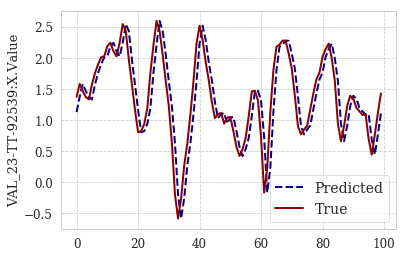

In [26]:
visualise_heuristic(predict_previous)

In [27]:
print("\nPREDICTING PREVIOUS")
val_prev, test_prev = evaluate_heuristic(predict_previous,y_valid,y_test)


PREDICTING PREVIOUS

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.90734 |             3063.82727 |
|  1 | VAL_23-TT-92539:X.Value    |              0.22107 |                0.21588 |
|  2 | VAL_23-PT-92539:X.Value    |              0.55857 |                0.13824 |
|  3 | Average                    |              0.56233 |             1021.39379 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL

### Predict the mean value of training data

In [28]:
target_means_stdized = np.mean(y_train, axis=0)
def predict_mean(y_data):   
    preds = target_means_stdized
    targets = y_data
    return preds, targets

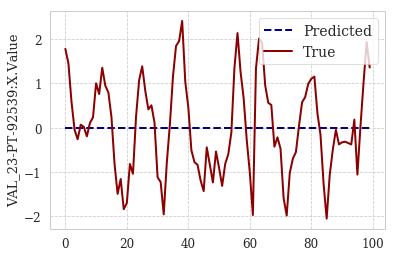

In [29]:
visualise_heuristic(predict_mean, signal=2)

In [30]:
print("\nPREDICTING MEAN")
val_mean, test_mean = evaluate_heuristic(predict_mean, y_valid, y_test)


PREDICTING MEAN

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.85733 |             2894.97683 |
|  1 | VAL_23-TT-92539:X.Value    |              1.38544 |                1.35287 |
|  2 | VAL_23-PT-92539:X.Value    |              0.83292 |                0.20613 |
|  3 | Average                    |              1.02523 |              965.51194 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-

### Predicting the moving average 
---
Initial value of the mean of the trainign data

In [31]:
def predict_ma(y_data):
    cumsum = np.cumsum(y_data, axis=0)
    ma = np.array([cumsum[n-1]/n for n in range(1,len(cumsum)+1)])
    
    preds = ma[:-1]
    targets = y_data[1:]
    return preds, targets

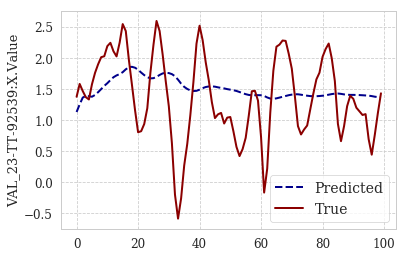

In [32]:
visualise_heuristic(predict_ma)

In [33]:
print("\nPREDICTING MOVING AVERAGE")
val_ma, test_ma = evaluate_heuristic(predict_ma, y_valid, y_test)


PREDICTING MOVING AVERAGE

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.83432 |             2817.25905 |
|  1 | VAL_23-TT-92539:X.Value    |              0.71028 |                0.69358 |
|  2 | VAL_23-PT-92539:X.Value    |              0.83317 |                0.20620 |
|  3 | Average                    |              0.79259 |              939.38627 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0

## TODO: Summary

# Linear Regression
---

In [200]:
def evaluate_linear_model(model, x_valid=x_valid, y_valid=y_valid, x_test=x_test, y_test=y_test):
    """
    Prints the performance of a model on the validation and testing data. Returns dictionaries of the validation
    and testing error. 
    
    :param model: The fitted model that can use the .predict() function
    :param x_valid: matrix of validation features. Default=x_valid.
    :param y_valid: matrix of validation targets. Default=y_valid.
    :param x_test: matrix of test features. Default=x_test.
    :param y_test: matrix of test targets. Default=y_test. 
    
    :return: dictionaries of validation and test errors as returned from evaluate_error()
    """
    
    print("\n       Validation data")
    preds = model.predict(x_valid)
    targets = y_valid
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\n       Testing data")
    preds = model.predict(x_test)
    targets = y_test
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

In [201]:
def plot_linear_model(model, x_data=x_valid, y_data=y_valid, start_idx=0, n_obs=200, signal=1):
    """
    Plots a sample of the linear model.
    """
    preds = model.predict(x_data)
    targets = y_data
    
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
    for i in range(len(target_tags)):
        ax = axs[i]
        tag = target_tags[i]
        ax.plot(preds[start_idx:start_idx+n_obs,i], c="darkblue", lw=2, label="pred")
        ax.plot(targets[start_idx:start_idx+n_obs,i], c="darkred", lw=2, label="true")
        
        ax.set_title(target_tags[i])
        ax.legend(frameon=True) 
    
    fig.show()

In [202]:
feature_tags

array(['VAL_23-FT-92512:X.Value', 'VAL_23-FT-92521:X.Value',
       'VAL_23-KA-9101-M01-62B:X.Value', 'VAL_23-KA-9101_APE:VALUE',
       'VAL_23-KA-9101_APH:VALUE', 'VAL_23-KA-9101_APR:VALUE',
       'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_EPE:VALUE',
       'VAL_23-KA-9101_EPH:VALUE', 'VAL_23-KA-9101_EPR:VALUE',
       'VAL_23-KA-9101_ESP:VALUE', 'VAL_23-KA-9101_PHD:VALUE',
       'VAL_23-KA-9101_PRD:VALUE', 'VAL_23-KA-9101_SPD:VALUE',
       'VAL_23-LIC-92521:Z.X.Value', 'VAL_23-LIC-92521:Z.Y.Value',
       'VAL_23-LT-92523:Z.X1.Value', 'VAL_23-LT-92523:Z.X2.Value',
       'VAL_23-PDT-92502:X.Value', 'VAL_23-PDT-92522:X.Value',
       'VAL_23-PDT-92530:X.Value', 'VAL_23-PDT-92534:X.Value',
       'VAL_23-PT-92504:X.Value', 'VAL_23-PT-92512:X.Value',
       'VAL_23-PT-92521:X.Value', 'VAL_23-PT-92523:X.Value',
       'VAL_23-PT-92532:X.Value', 'VAL_23-PT-92535:X.Value',
       'VAL_23-TIC-92504:Z.X.Value', 'VAL_23-TT-92502:X.Value',
       'VAL_23-TT-92512:X.Value', 'VAL_23-TT-925

In [210]:
tag_importance_sorted

[('VAL_23-KA-9101_EPR:VALUE', 0.8790280867336411),
 ('VAL_23-KA-9101_ESP:VALUE', 0.07957524523096703),
 ('VAL_23-LT-92523:Z.X1.Value', 0.018210953818172487),
 ('VAL_23-KA-9101_EPE:VALUE', 0.010889132368679427),
 ('VAL_23-LIC-92521:Z.Y.Value', 0.00908524360406909),
 ('VAL_23-KA-9101_EPH:VALUE', 0.002887423876919323),
 ('VAL_23-KA-9101_APH:VALUE', 0.00017453482140774776),
 ('VAL_23-FT-92512:X.Value', 9.47341303166737e-05),
 ('VAL_23-KA-9101_APE:VALUE', 3.155274509239325e-05),
 ('VAL_23-KA-9101_PRD:VALUE', 6.19772084271587e-06),
 ('VAL_23-KA-9101-M01-62B:X.Value', 3.8894070746309316e-06),
 ('VAL_23-LIC-92521:Z.X.Value', 3.3846642390834517e-06),
 ('VAL_23-KA-9101_SPD:VALUE', 2.6551855212036414e-06),
 ('VAL_23-KA-9101_APR:VALUE', 2.2672003409400037e-06),
 ('VAL_23-KA-9101_ASP:VALUE', 2.1260034650235063e-06),
 ('VAL_23-KA-9101_PHD:VALUE', 1.8514428410285696e-06),
 ('VAL_23-FT-92521:X.Value', 7.210464119509972e-07)]

In [211]:
x_train.shape

(53211, 17)

[]
(53211, 41) (53211, 3)
(17737, 41) (17737, 3)


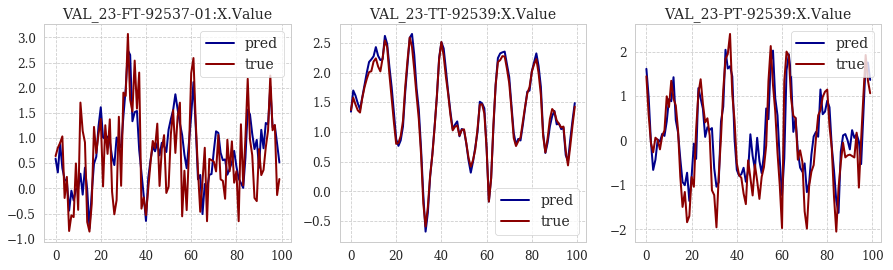

In [226]:
# remove features from the dataset
n_remove = 0
delete_tags = [tup[0] for tup in tag_importance_sorted[:n_remove]]
delete_idxs = [np.where(feature_tags == tag)[0][0] for tag in delete_tags]
print(delete_tags)

x_train, y_train = split_dataset(np.delete(scaled_train, delete_idxs, axis=1))
x_valid, y_valid = split_dataset(np.delete(scaled_valid, delete_idxs, axis=1))
x_test, y_test = split_dataset(np.delete(scaled_test, delete_idxs, axis=1))

x_train_delayed = x_train[:-1]
y_train_delayed = y_train[1:]

x_valid_delayed = x_valid[:-1]
y_valid_delayed = y_valid[1:]

x_test_delayed = x_test[:-1]
y_test_delayed = y_test[1:]


print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

# test that the data is lagged correctly
assert len(x_train) == len(x_train_delayed)+1
assert np.all(x_train[-2] == x_train_delayed[-1])
assert len(y_train) == len(y_train_delayed)+1
assert np.all(y_train_delayed[0] == y_train[1])

# test that the features are deleted
assert x_train.shape[-1] == scaled_train.shape[-1]-len(target_tags)-len(delete_tags)

lm = LinearRegression()
lm.fit(x_train_delayed, y_train_delayed)

plot_linear_model(lm, x_valid_delayed, y_valid_delayed, n_obs=100)

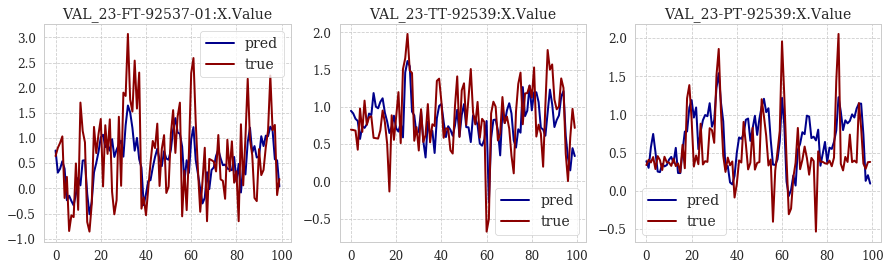

In [176]:
from sklearn.linear_model import LinearRegression
# using the standard settings https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

lm = LinearRegression()
lm.fit(x_train_delayed, y_train_delayed)

plot_linear_model(lm, x_valid_delayed, y_valid_delayed, n_obs=100)


In [133]:
print("\n LINEAR REGRESSION MODEL")
val_linear, test_linear = evaluate_linear_model(lm, x_valid_delayed, y_valid_delayed, x_test, y_test)


 LINEAR REGRESSION MODEL

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.68179 |             2302.20666 |
|  1 | VAL_23-TT-92539:X.Value    |              0.12015 |                0.11733 |
|  2 | VAL_23-PT-92539:X.Value    |              0.48519 |                0.12008 |
|  3 | Average                    |              0.42904 |              767.48135 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 

In [ ]:
import os
from cognite.client import CogniteClient
client = CogniteClient(api_key=os.environ['COGNITE_API_SECRET'])

scrubber_file_name = 'PH-ME-P-0153-001'
client.files.list_files(name=scrubber_file_name).to_pandas()

client.files.download_file(client.files.list_files(name=scrubber_file_name).to_pandas().id[0])

# Random Forest

In [205]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [206]:
params_rf = {'n_estimators': 1000, 
             'max_depth': 5, 
             'min_samples_split': 2, 
             'max_features': 'auto', 
             'criterion': 'mse', 
             'random_state': 0, 
             'n_jobs': -1, 
             'oob_score': True,
             'verbose': 1
            }

rf = RandomForestRegressor(**params_rf)

In [207]:
rf.fit(x_train_delayed, y_train_delayed[:,1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   38.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=0, verbose=1, warm_start=False)

In [208]:
print("Average Imp.:            ", np.average(rf.feature_importances_))
print("Average Imp. > 0:        ", np.average(rf.feature_importances_[rf.feature_importances_ > 0]))
print("# of Feature Imp. > 0:   ",len(rf.feature_importances_[rf.feature_importances_ > 0]))

Average Imp.:             0.05882352941176481
Average Imp. > 0:         0.05882352941176481
# of Feature Imp. > 0:    17


In [228]:
print(len(feature_tags),len(rf.feature_importances_))

41 17


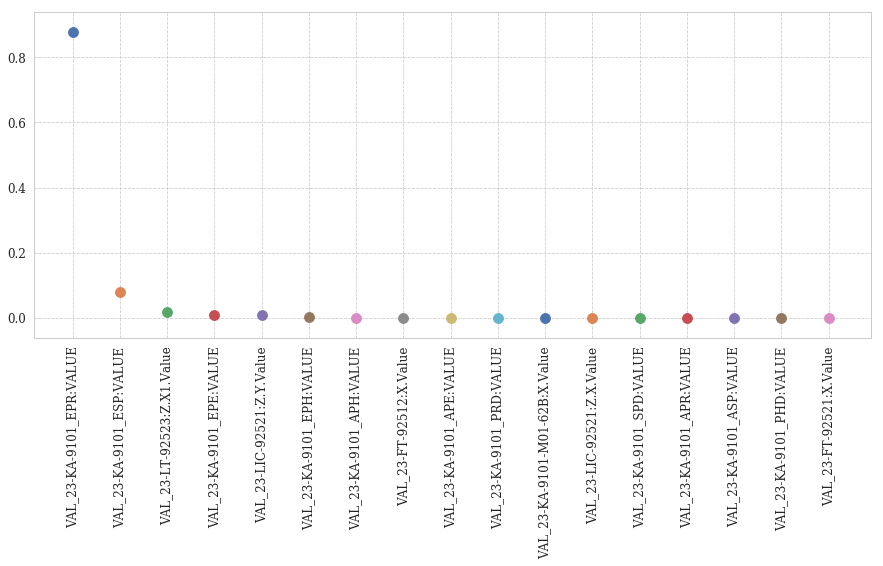

In [209]:
tag_importance = list(zip(feature_tags, rf.feature_importances_))
tag_importance_sorted = sorted(tag_importance, key=lambda tag: tag[1], reverse=True)

values = [tup[1] for tup in tag_importance_sorted]
plt.figure(figsize=(15,6))
for i, (tag, imp) in enumerate(tag_importance_sorted):
    plt.scatter(x=i, y=imp, label=tag, s=100)

xticks = [tup[0] for tup in tag_importance_sorted]
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()



In [109]:
def evaluate_ml(model, params, ntrees_per_signal, 
                use_multivariate=False,
                x_train=x_train, y_train=y_train, 
                x_valid=x_valid, y_valid=y_valid, 
                x_test=x_test, y_test=y_test):
    
    val_predictions = np.zeros(y_valid.shape)
    test_predictions = np.zeros(y_test.shape)
    
    if use_multivariate:
        model.fit(x_train, y_train)
        val_predictions = model.predict(x_valid)
        test_predictions = model.predict(x_test)

    else: 
        for signal in range(y_train.shape[-1]):
            ntrees = ntrees_per_signal[signal]
            params['n_estimators'] = ntrees
            model.set_params(**params)
            model.fit(x_train, y_train[:,signal])

            val_predictions[:,signal] = model.predict(x_valid)
            test_predictions[:,signal] = model.predict(x_test)
    
    val_errs = evaluate_error(val_predictions, y_valid)
    test_errs = evaluate_error(test_predictions, y_test)
    
    print("\n       Validation data")
    print(val_errs['err_table'])
    
    print("\n       Testing data")
    print(test_errs['err_table'])
    
    return [val_errs, test_errs]

In [112]:
ntrees = 500
params_rf = {'n_estimators': ntrees, 'max_depth': None, 'min_samples_split': 2, 'max_features':'auto', 
             'criterion':'mse', 'random_state':0, 'n_jobs':-1, 'oob_score':True}

print("___ Multivariate ___")
evaluate_ml(rf, params_rf, ntrees_per_signal=[ntrees,ntrees,ntrees], 
            use_multivariate=True,
            x_train = x_train_delayed, y_train = y_train_delayed,
            x_valid = x_valid_delayed, y_valid = y_valid_delayed,
            x_test = x_test_delayed, y_test = y_test_delayed)

print("___ Individual ___")
evaluate_ml(rf, params_rf, ntrees_per_signal=[ntrees,ntrees,ntrees], 
            use_multivariate=False,
            x_train = x_train_delayed, y_train = y_train_delayed,
            x_valid = x_valid_delayed, y_valid = y_valid_delayed,
            x_test = x_test_delayed, y_test = y_test_delayed)



___ Multivariate ___

       Validation data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL_23-FT-92537-01:X.Value |              0.64278 |             2170.50465 |
|  1 | VAL_23-TT-92539:X.Value    |              0.38726 |                0.37816 |
|  2 | VAL_23-PT-92539:X.Value    |              0.46581 |                0.11528 |
|  3 | Average                    |              0.49862 |              723.66603 |
+----+----------------------------+----------------------+------------------------+

       Testing data
+----+----------------------------+----------------------+------------------------+
|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |
|----+----------------------------+----------------------+------------------------|
|  0 | VAL

[{'err_df':                           Tag MAE (Standardized) MAE (Unstandardized)
  0  VAL_23-FT-92537-01:X.Value           0.636707              2149.99
  1     VAL_23-TT-92539:X.Value           0.256584             0.250552
  2     VAL_23-PT-92539:X.Value           0.463229             0.114641
  3                     Average           0.452173              716.784,
  'err_table': '+----+----------------------------+----------------------+------------------------+\n|    | Tag                        |   MAE (Standardized) |   MAE (Unstandardized) |\n|----+----------------------------+----------------------+------------------------|\n|  0 | VAL_23-FT-92537-01:X.Value |              0.63671 |             2149.98639 |\n|  1 | VAL_23-TT-92539:X.Value    |              0.25658 |                0.25055 |\n|  2 | VAL_23-PT-92539:X.Value    |              0.46323 |                0.11464 |\n|  3 | Average                    |              0.45217 |              716.78386 |\n+----+------------

In [86]:
from sklearn.ensemble import RandomForestRegressor
params_rf = {'n_estimators': 1500, 'max_depth': None, 'min_samples_split': 2, 'max_features':'auto', 
             'criterion':'mse', 'random_state':0, 'n_jobs':-1, 'oob_score':True}

rf = RandomForestRegressor(**params_rf)

def get_oob_per_tree(rf_model, x_train, y_train, ntrees_min=50, ntrees_max=2000, delta=50):
    
    trees_arr = np.arange(ntrees_min,ntrees_max+delta,delta)
    oob_errors = np.zeros(len(trees_arr))
    best_trees = trees_arr[0]
    best_err = np.inf
    
    for i, ntrees in enumerate(trees_arr):
        params_rf['n_estimators'] = ntrees
        rf_model.set_params(**params_rf)
        rf_model.fit(x_train, y_train)
        
        print("ntrees={0}, oob_error={1}".format(ntrees,round(1 - rf_model.oob_score_,5)))
        err = 1 - rf_model.oob_score_
        oob_errors[i] = err
        
        if err < best_err:
            best_err = err
            best_trees = ntrees
        
    return oob_errors, best_trees

ntrees_min = 100
ntrees_max = 1500
delta = 100

oob_errors, best_trees = get_oob_per_tree(rf, x_train_delayed, y_train_delayed, ntrees_min, ntrees_max, delta)

ntrees=100, oob_error=0.03313
ntrees=200, oob_error=0.03221
ntrees=300, oob_error=0.0319
ntrees=400, oob_error=0.03177
ntrees=500, oob_error=0.0317
ntrees=600, oob_error=0.03165
ntrees=700, oob_error=0.03161
ntrees=800, oob_error=0.03159
ntrees=900, oob_error=0.03157
ntrees=1000, oob_error=0.03156
ntrees=1100, oob_error=0.03155
ntrees=1200, oob_error=0.03153


KeyboardInterrupt: 

In [ ]:
best_trees = 500
ntrees = 50; print(best_trees)

plt.figure()
plt.plot(np.arange(ntrees_min,ntrees_max+delta,delta), oob_errors, marker='o', markersize=3.0, color="darkblue")
plt.vlines(x=ntrees,ymin=plt.ylim()[0],ymax=plt.ylim()[1], linestyle="dotted", color="darkred")
plt.xlabel('Number of trees')
plt.ylabel('OOB error rate')
plt.show()

In [ ]:
print(x_train.shape, x_valid.shape, x_test.shape)

NameError: name 'val_predictions' is not defined

# ---- #







In [82]:
params_rf = {'n_estimators': 500, 
             'max_depth': 5, 
             'min_samples_split': 2, 
             'max_features': 'auto', 
             'criterion': 'mse', 
             'random_state': 0, 
             'n_jobs': -1, 
             'oob_score': True,
             'verbose': 1
            }
rf = RandomForestRegressor(**params_rf)
signal =1
rf.fit(x_train, y_train[:,signal])
evaluate_ml(rf, y_valid=y_valid[:,signal], y_test=y_test[:,signal])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    0.1s finis


       Validation data
VAL_23-FT-92537-01:X.Value: 0.40417665482334497

       Testing data
VAL_23-TT-92539:X.Value: 0.3567640927920729


[]

In [81]:
evaluate_ml(rf, y_valid=y_valid[:,signal], y_test=y_test[:,signal])

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished



       Validation data
VAL_23-FT-92537-01:X.Value: 0.4060365326194052

       Testing data
VAL_23-TT-92539:X.Value: 0.35834912789028395


[]